In [15]:
%load_ext autoreload
%autoreload 2
#---------------------------Imports-------------------------------------------
import numpy as np
import pandas as pd
import os
import glob
import importlib
import matplotlib.pyplot as plt

import sys

# Add Help_functions directory to the system path - Kommer bli en del sånt nu framöver
sys.path.append(os.path.join(os.getcwd(), 'Help_functions'))


import sympy as sp
from Data_Cleaning_test import*


#----------------------------load_data delete ()-----------------------------------
folder_path = 'C:\\Users\\Master_Student\\ml\\Data\\data_oct_2023\\features\\'
df = import_and_combine_data(folder_path)
# Delete all parentheses in column names, this for PySRRegressor to work
df.columns = df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip()
#print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#---------------------------Fix Missing data-------------------------------------------
def fix_missing_data(group):
    # Interpolate
    group = group.interpolate(method='linear')
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    return group

# Apply all operations in a single pass
grouped = df.groupby(['round', 'device'], group_keys=False)
df = grouped.apply(fix_missing_data)

df['swing_temperature'] = df['max_temperature'] - df['min_temperature'] 

#-----------------------------Abbrevations for plotting---------------------------------------------

temperature_columns = [
    'min_temperature', 
    'max_temperature', 
    'min_block_temperature_1', 
    'max_block_temperature_1', 
    'min_block_temperature_2', 
    'max_block_temperature_2', 
    'avg_max_block_temperature', 
    'min_water_inlet_temperature',
    'max_water_inlet_temperature', 
    'min_water_outlet_temperature', 
    'max_water_outlet_temperature', 
]
# Create the abbreviation dictionary for renaming the columns
abbreviations = {
    'cycle': 'Cyc',
    'consumed_life': 'CL',
    'end_voltage': 'V_end',
    'end_resistance': 'R_end',
    'end_resistance_residual': 'R_res',
    'end_resistance_residual_cleaned': 'R_res_cl',
    'min_temperature': 'T_min',
    'max_temperature': 'T_max',
    'min_block_temperature_1': 'T_B1_min',
    'max_block_temperature_1': 'T_B1_max',
    'min_block_temperature_2': 'T_B2_min',
    'max_block_temperature_2': 'T_B2_max',
    'avg_max_block_temperature': 'T_B_avg_max',
    'min_water_inlet_temperature': 'T_WI_min',
    'max_water_inlet_temperature': 'T_WI_max',
    'min_water_outlet_temperature': 'T_WO_min',
    'max_water_outlet_temperature': 'T_WO_max',
    'swing_temperature': 'T_Sw'
} 

columns_to_clean = ['end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'swing_temperature'] # tar bort cycle!

# Function to replace column names with abbreviations
def get_abbreviation(column_name):
    return abbreviations.get(column_name, column_name)  # Use the abbreviation if it exists, otherwise use the original name



#---------------------------------------Get rid of unphyiscal temperature drops in the data---------------------------------------------------------------

#-----------------------------------------------Filtrera datan-----------------------------------------------------

df = df[~((df['round'] == 9) & (df['device'] == 1) & (df['consumed_life'] > 0.98))]

# Filter data for device 1 in round 9
condition = (df['round'] == 9) & (df['device'] == 1)

# Calculate the new 'consumed_life' as the normalized 'cycle' for the remaining rows
df.loc[condition, 'consumed_life'] = (
    df.loc[condition, 'cycle'] / df.loc[condition, 'cycle'].max())
# Define the cycle threshold
cycle_threshold = 25000
# Filter data for device 10 in round 9
df = df[~((df['round'] == 9) & (df['device'] == 10) & (df['cycle'] >= cycle_threshold))]
# Apply condition to filter remaining data for round 9, device 10
condition = (df['round'] == 9) & (df['device'] == 10)
# Calculate the new 'consumed_life' as the normalized 'cycle' for the remaining rows
df.loc[condition, 'consumed_life'] = (
    df.loc[condition, 'cycle'] / df.loc[condition, 'cycle'].max()
)

#-------------------------------------------------
devices = list(range(1,11)) # ska vara 11 här !
rounds = [8, 9]

segmented_data = make_segments(
    df=df,
    devices=devices,
    rounds=rounds,
    cut_at_CL_one=True,       # Remove rows with consumed_life > 1      # Minimum segment size to keep
    cycle_threshold=2000       # Remove rows with cycle < 500
)


filtered_data = exclude_transition_cycles(
    segmented_data=segmented_data, 
    transition_margin=100,  # Standard transition margin 75 förr
    filter_columns=columns_to_clean,
    verbose=True
)

merged_data, aligned_data = merge_segments(
    segmented_data=filtered_data,
    devices=devices,
    rounds=[8, 9],
    columns_to_merge= columns_to_clean,
    mean_interval_proportion=0.1, # 0.1
    min_interval=10,
    max_interval=500,
    transition_margin=10
)

#print(adjusted_segmented_data)
filled_merged_data, gap_statistics = fill_gaps(
   merged_data=merged_data,
   columns_to_fill=columns_to_clean,
    window_size= 1000
)

window_size = 250  
m_average_data = calculate_moving_averages(filled_merged_data, window_size)
convert_temperatures_to_kelvin(m_average_data, temperature_columns)

#--------------------------------------------Stratified sampling---------------------------------------------------------------------
with_initial_values = add_initial_values(m_average_data, verbose = False)

sampled_data_dict = systematic_sample_device_data(data_dict =with_initial_values, rounds = rounds, devices = devices, column_to_sample='cycle', n_samples=500, verbose =True)

round_dict_un_sampled = devices_combined_into_one_df(with_initial_values , [8,9]) 
round_dict = devices_combined_into_one_df(sampled_data_dict , [8,9]) #--------------- bra

combined_df_unsampled = combine_all_rounds(round_dict_un_sampled)
combined_df = combine_all_rounds(round_dict)


C:\Users\Master_Student\AppData\Local\Temp\ipykernel_7468\289070922.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fix_missing_data)


segment_devices_data:
Total rows removed: 66000.00 out of 1052826.00 (6.27%)
Rows removed due to consumed_life > 1: 26020.00
Rows removed due to cycle < 2000.00: 39980.00
----------------------------------------------------------------------------
exclude_transition_cycles:
Total rows marked as NaN: 24125.00 out of 986826.00 (2.44%)
Total individual NaN values marked: 386000.00
----------------------------------------------------------------------------
fill_gaps:
Total NaN values filled: 386,000 out of 15,789,216 values (2.44%)
Gap Statistics: Max=343.00, Min=200.00, Mean=213.50, Std=38.30, Total Gaps=1808.00
----------------------------------------------------------------------------
calculate_moving_averages
Total rows removed: 4980 out of 986826 (0.50%)
Expected rows removed due to window size (250): 4980.00
--------------------------------------------------------------------------------------------
All devices sampled successfully with the expected number of samples.


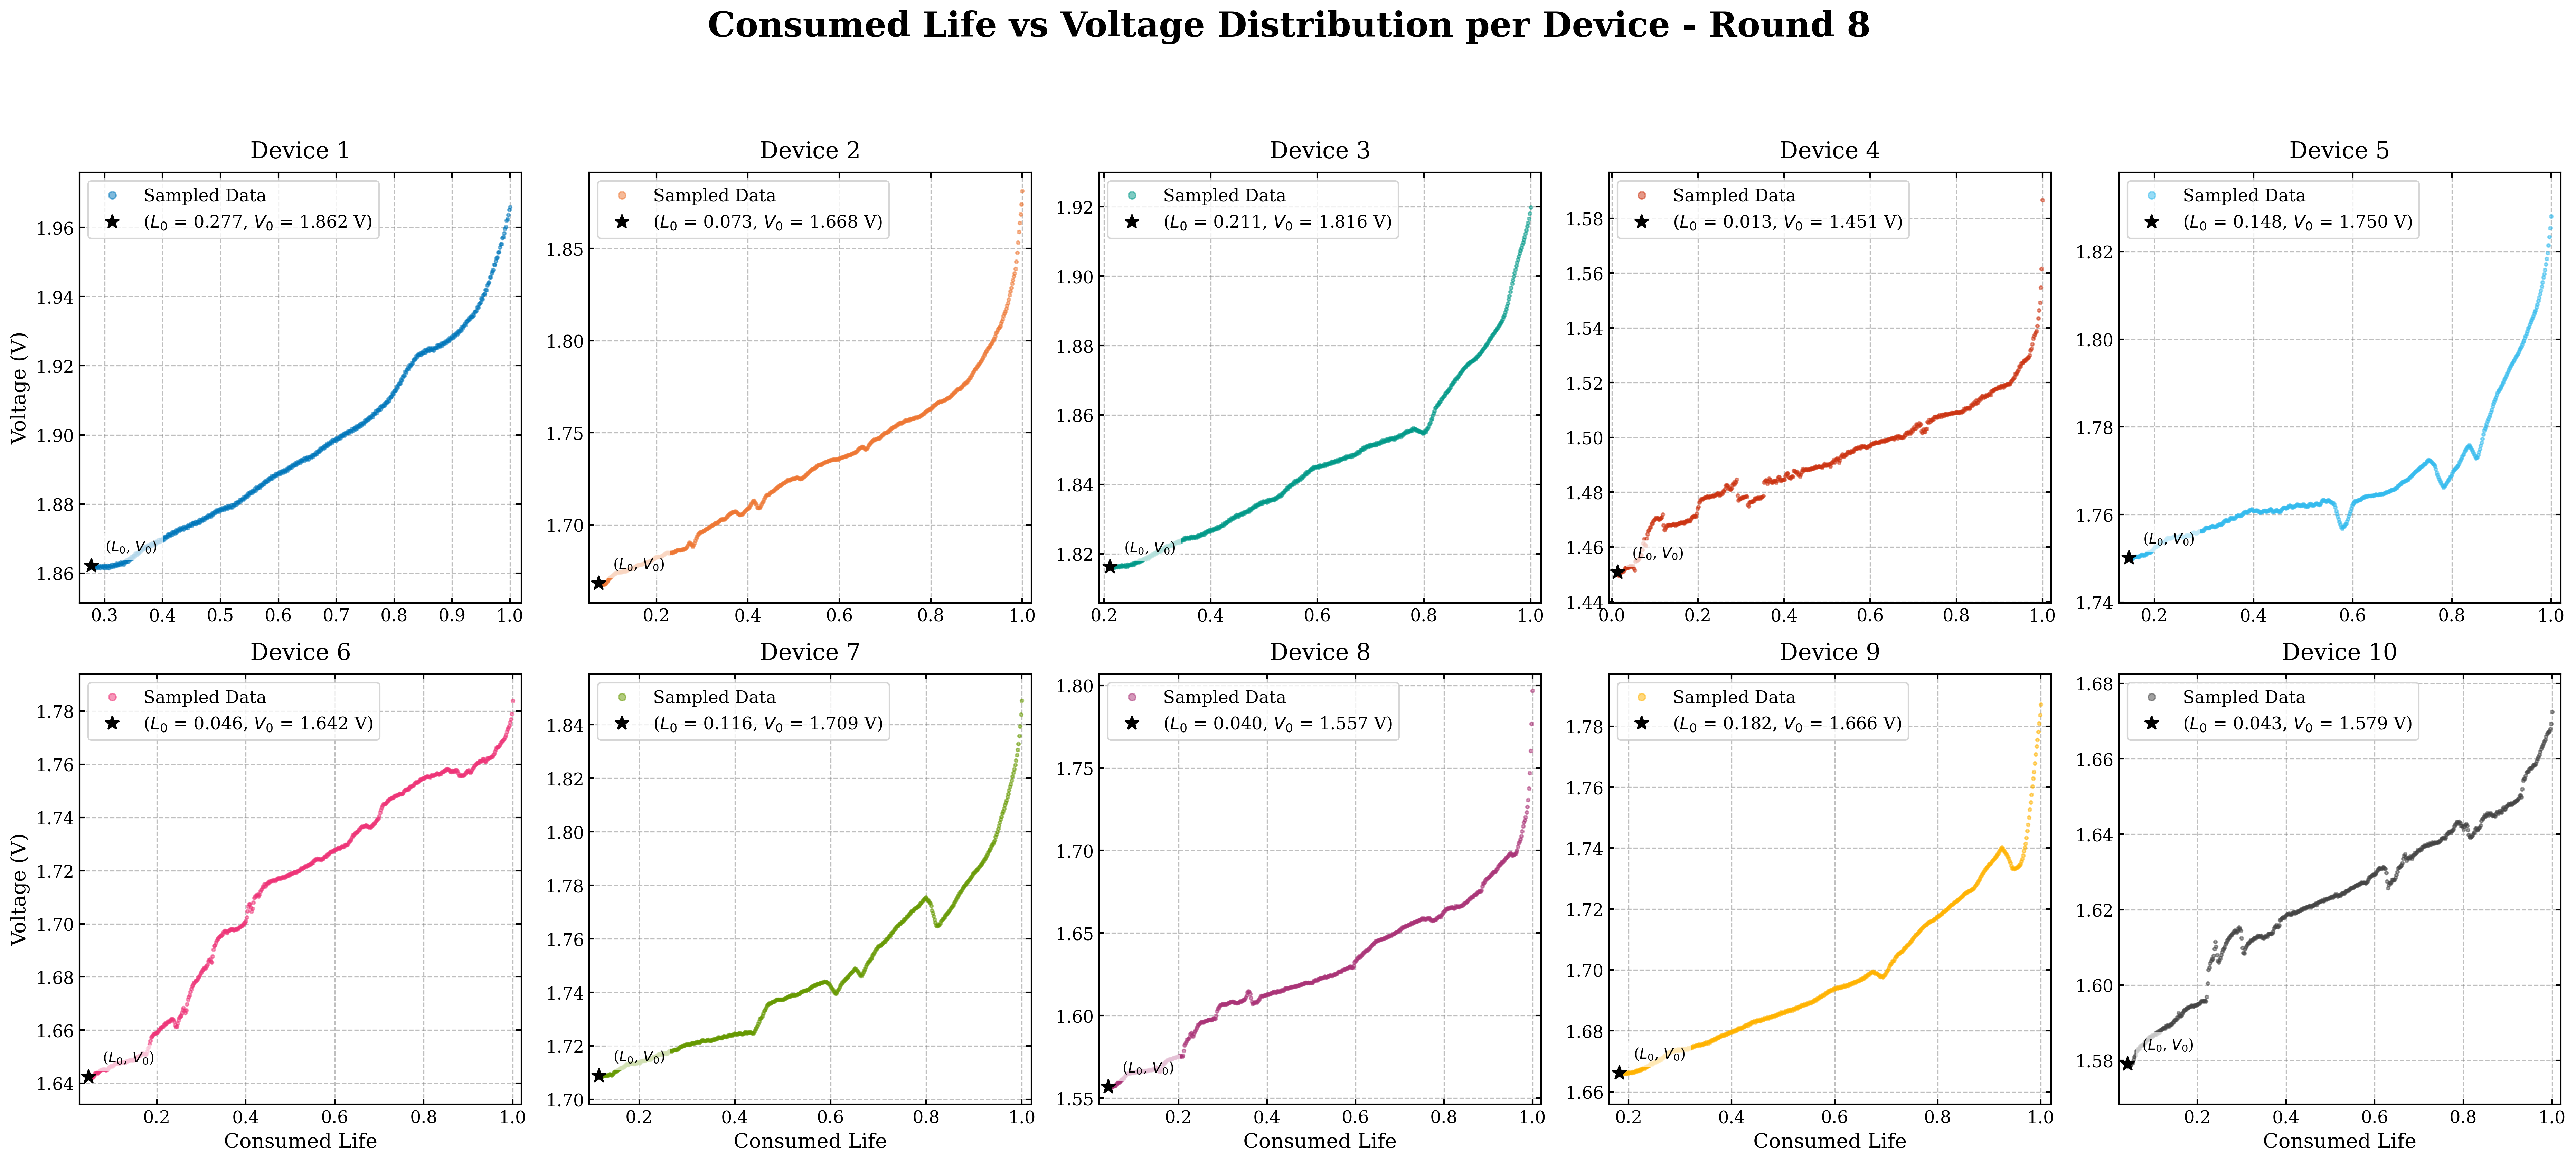

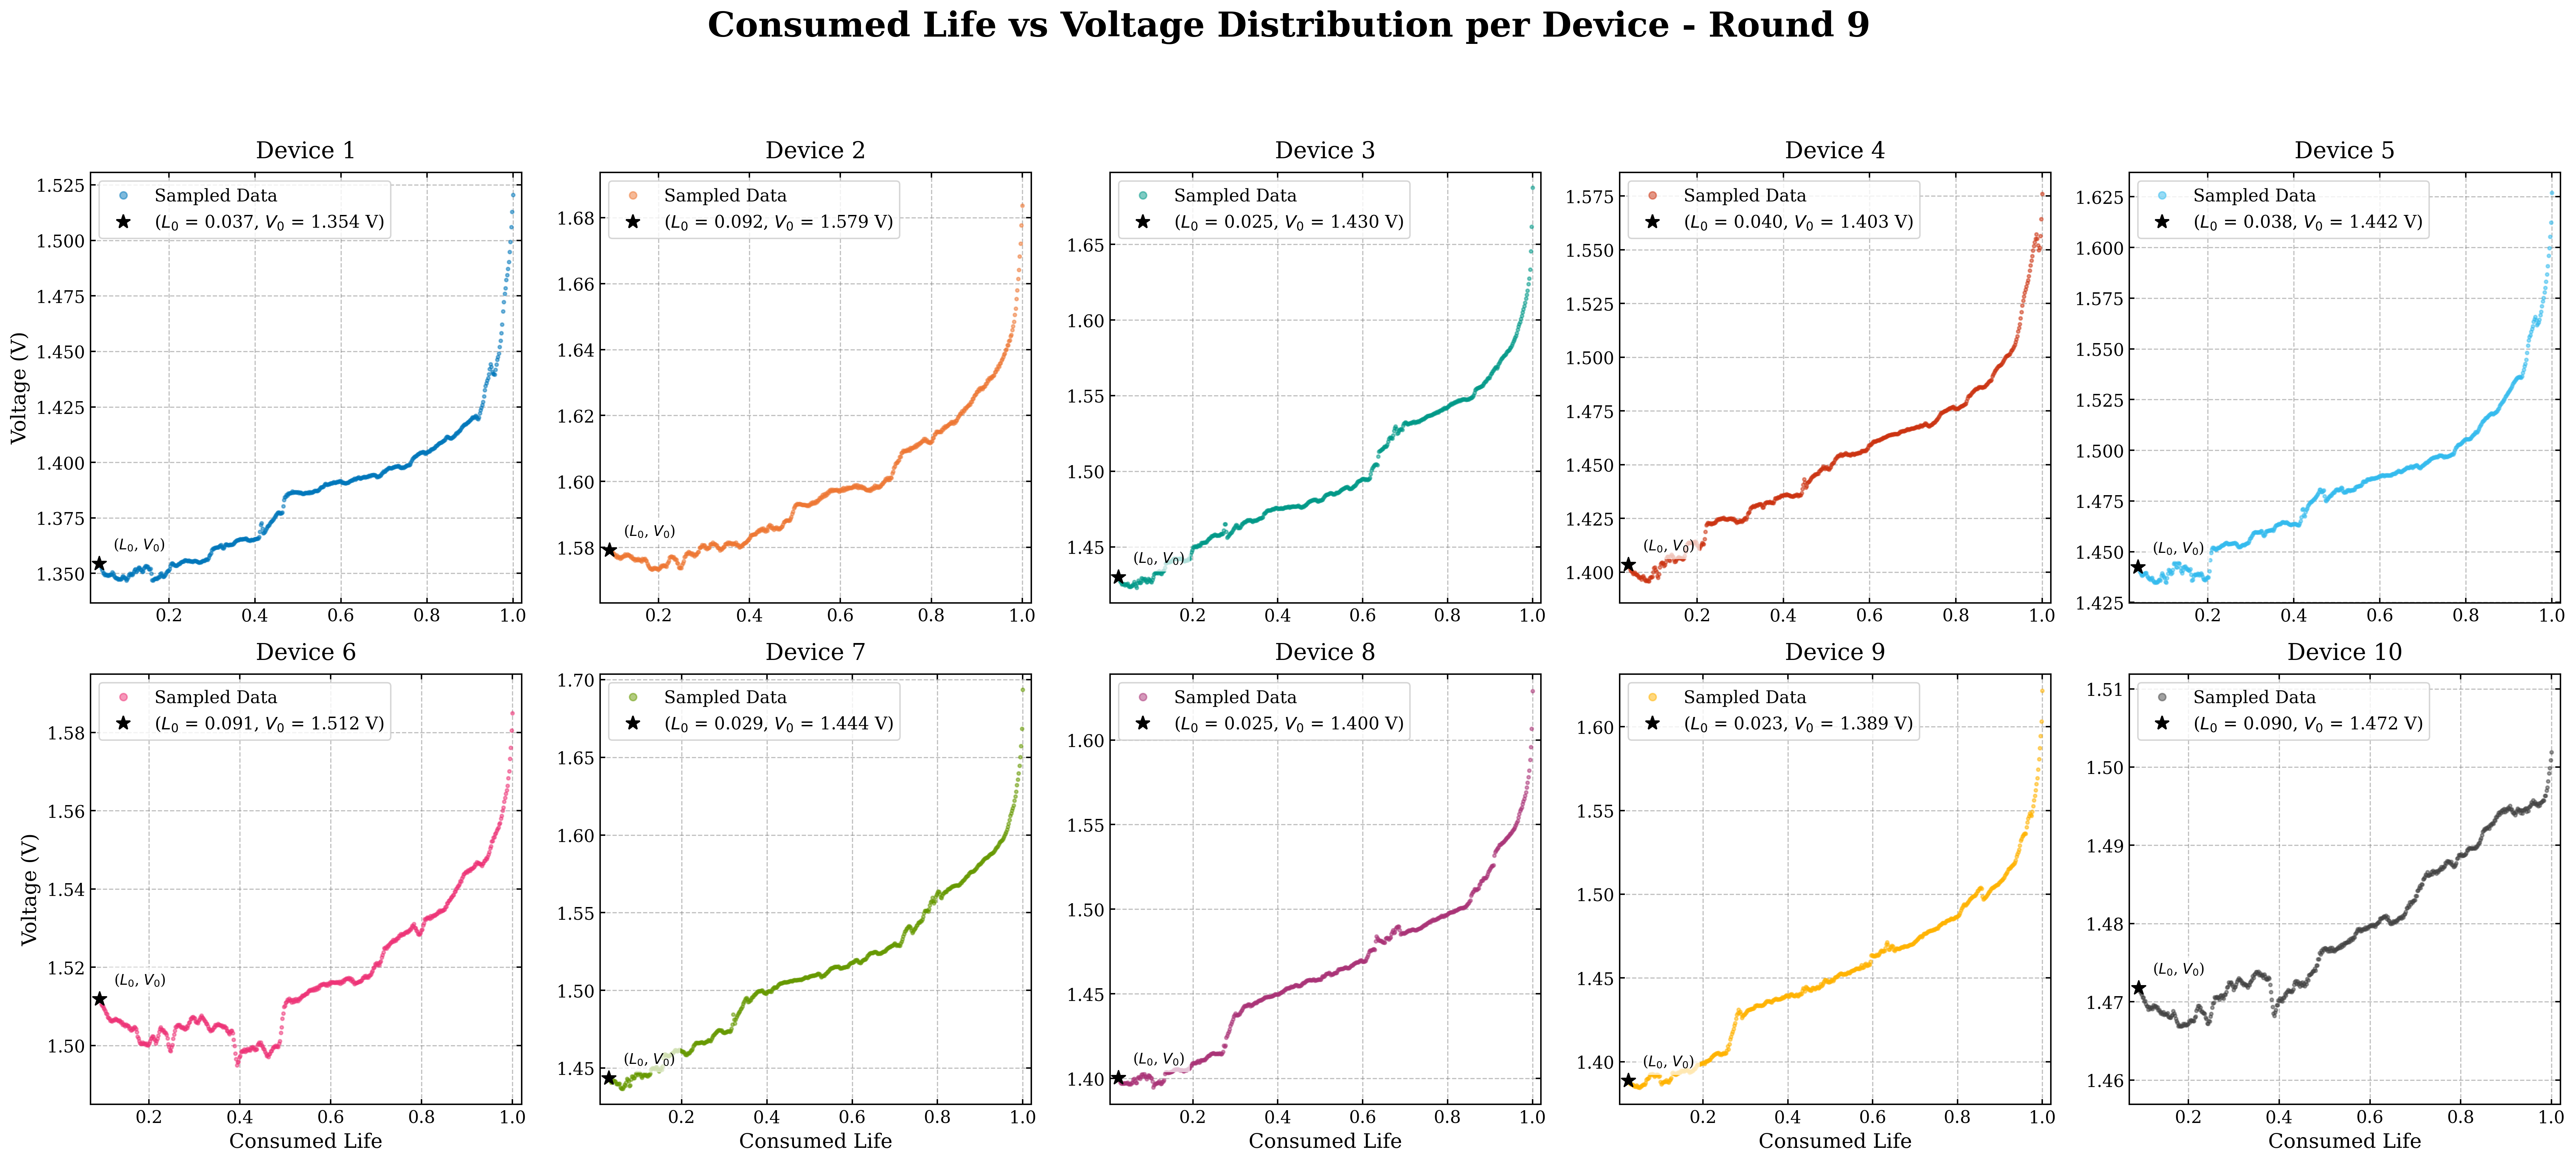

In [17]:
def plot_data_comparison(m_average_data, X, y, round_number=8, show_original=True):
    """
    Plot end voltage vs consumed life data showing both original and sampled data.
    
    Parameters:
    - m_average_data: Original nested dictionary {round: {device: [DataFrame]}}
    - X: DataFrame with features including consumed life data
    - y: Series with voltage data
    - round_number: Round number to plot (default=8)
    - show_original: Boolean to control if original data should be plotted (default=True)
    """
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np
    
    # Create figure with subplots and space for legend at bottom
    fig = plt.figure(figsize=(25, 12), facecolor='white')
    
    # Create GridSpec to make space for legend
    gs = plt.GridSpec(3, 5, height_ratios=[1, 1, 0.2])
    
    # Define colors
    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE', 
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']
    
    # Ensure round_number exists in the data
    if round_number not in m_average_data:
        raise ValueError(f"Round number {round_number} not found in m_average_data")
    
    # Create and populate subplots
    axs = []
    for i in range(10):
        ax = fig.add_subplot(gs[i // 5, i % 5])
        axs.append(ax)
        
        device_num = i + 1  # Devices are numbered 1-10
        
        try:
            original_df = m_average_data[round_number][device_num]
        except KeyError:
            print(f"Warning: No original data found for device {device_num} in round {round_number}")
            original_df = pd.DataFrame(columns=['consumed_life', 'end_voltage'])
        
        # Plot original data in grey if show_original is True
        if show_original and not original_df.empty:
            ax.scatter(original_df['consumed_life'],
                      original_df['end_voltage'],
                      color='grey',
                      alpha=0.2,
                      s=10,
                      marker='.',
                      zorder=1,
                      label='Original Data')
        
        # Create device mask more safely
        try:
            if 'round' in X.columns:
                device_mask = (X['round'] == round_number) & (X['device'] == device_num)
            else:
                # Assuming round_dict is available in the global scope
                device_mask = round_dict[round_number]['device'] == device_num
        except Exception as e:
            print(f"Warning: Error creating device mask for device {device_num}: {str(e)}")
            device_mask = pd.Series(False, index=X.index)
        
        # Check if we have any data for this device
        if not device_mask.any():
            print(f"Warning: No sampled data found for device {device_num} in round {round_number}")
            ax.text(0.5, 0.5, 'No data available', 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes)
            continue
        
        # Create device_data DataFrame safely
        try:
            device_data = pd.DataFrame({
                'consumed_life': X.loc[device_mask, 'consumed_life'],
                'end_voltage': y[device_mask],
                'init_end_voltage': X.loc[device_mask, 'init_end_voltage'],
                'init_consumed_life': X.loc[device_mask, 'consumed_life'].min()
            })
            
            if device_data.empty:
                print(f"Warning: Empty device data for device {device_num}")
                continue
                
            device_data = device_data.sort_values('consumed_life')
            v0 = device_data['init_end_voltage'].iloc[0]
            l0 = device_data['init_consumed_life'].iloc[0]
            
            #print('x =', len(device_data['consumed_life']), 'y =', len(device_data['end_voltage']))

            # Plot sampled data points
            scatter = ax.scatter(device_data['consumed_life'],
                               device_data['end_voltage'],
                               label='Sampled Data',
                               color=colors[i],
                               alpha=0.5,
                               s=20,
                               marker='.',
                               zorder=2)
            
            # Plot initial point (L₀, V₀)
            ax.scatter(l0, v0, 
                      color='black',
                      s=100,
                      marker='*',
                      label=f'($L_0$, $V_0$)',
                      zorder=3)
            
            # Add text annotation for the point
            ax.annotate(f'($L_0$, $V_0$)', 
                       xy=(l0, v0),
                       xytext=(10, 10),
                       textcoords='offset points',
                       fontsize=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            
        except Exception as e:
            print(f"Error plotting device {device_num}: {str(e)}")
            continue
        
        # Customize subplot
        ax.set_title(f'Device {device_num}', fontsize=16, pad=10)
        ax.grid(True, linestyle='--', alpha=0.5, color='gray')
        ax.tick_params(axis='both', labelsize=12)
        
        # Set axis limits using available data
        if not device_data.empty:
            x_min = device_data['consumed_life'].min() - 0.02
            x_max = device_data['consumed_life'].max() + 0.02
            y_min = device_data['end_voltage'].min() - 0.01
            y_max = device_data['end_voltage'].max() + 0.01
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
        
        # Add axis labels
        if i >= 5:
            ax.set_xlabel('Consumed Life', fontsize=14)
        if i % 5 == 0:
            ax.set_ylabel('Voltage (V)', fontsize=14)
        
        # Add legend only if we have data
        if not device_data.empty:
            legend_elements = []
            if show_original and not original_df.empty:
                legend_elements.append(
                    Line2D([0], [0], color='grey', marker='.', linestyle='None',
                           label='Original Data', alpha=0.2, markersize=10))
            legend_elements.extend([
                Line2D([0], [0], color=colors[i], marker='.', linestyle='None',
                       label='Sampled Data', alpha=0.5, markersize=10),
                Line2D([0], [0], color='black', marker='*', linestyle='None',
                       label=f'($L_0$ = {l0:.3f}, $V_0$ = {v0:.3f} V)', 
                       markersize=10)
            ])
            ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
    
    # Add title
    fig.suptitle(f'Consumed Life vs Voltage Distribution per Device - Round {round_number}',
                 fontsize=24, fontweight='bold', y=1.02)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Example usage for round 8 and round 9
round_8_data = combined_df[combined_df['round'] == 8]
plot_data_comparison(with_initial_values, 
                    round_8_data[['consumed_life', 'init_consumed_life', 'init_end_voltage', 'round', 'device']], 
                    round_8_data['end_voltage'], 
                    round_number=8, 
                    show_original=False)

round_9_data = combined_df[combined_df['round'] == 9]
plot_data_comparison(with_initial_values, 
                    round_9_data[['consumed_life', 'init_consumed_life', 'init_end_voltage', 'round', 'device']], 
                    round_9_data['end_voltage'], 
                    round_number=9, 
                    show_original=False)


In [18]:
import os
import pickle
import uuid

# Define the custom output directory for temporary files
custom_output_directory = os.path.abspath("my_custom_output_directory")

# Ensure the temporary directory exists
if not os.path.exists(custom_output_directory):
    os.makedirs(custom_output_directory)

# Define the results directory for saving the final model
results_directory = os.path.abspath("Results")

# Ensure the results directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Generate a unique Hall of Fame file name to avoid conflicts
hall_of_fame_file = os.path.join(custom_output_directory, f"halloffame_{uuid.uuid4().hex}.csv")

# Test if the temporary file can be created
try:
    with open(hall_of_fame_file, "w") as f:
        f.write("Testing write access.\n")
    print(f"Successfully created test file: {hall_of_fame_file}")
except PermissionError:
    raise PermissionError(f"Cannot write to the specified directory: {custom_output_directory}")

Successfully created test file: c:\Users\Master_Student\ml\MyCode\my_custom_output_directory\halloffame_61555a27bde345c5b197dd723e181739.csv


In [19]:
import os
import pickle
from pysr import PySRRegressor

Time_in_hours = 1/60

# Prepare the data for the current round
X = combined_df[['consumed_life', 'init_consumed_life', 'init_end_voltage']]

# Create target vector y
y = combined_df['end_voltage']

# Rename the column in y
y = y.rename("V")

# Rename columns in X
X = X.rename(columns={
    'consumed_life': 'CL',
    'init_consumed_life': 'CL_0',
    'init_end_voltage': 'V_0'
   })

# Initialize PySRRegressor
model = PySRRegressor(
    niterations=15_000,
    timeout_in_seconds= 60*60*Time_in_hours, # notera att det körs två rundor
    elementwise_loss="L2DistLoss()",
    warm_start=False,
    binary_operators=["+", "*", "-", "/"], # lägger till greater than tar bort "^", "greater"
    unary_operators=[ "square"], #"exp", "log"
    constraints={'*': (3, 3)}, # "^": (-1, 1)
    nested_constraints={ #"exp": { "exp": 0, "log": 0, "square": 0}, 
                        #"log": {"log": 0, "exp": 0},
                        "square": {"square": 0},
       },
    progress=False,
    bumper=True,
    population_size=75,
    tournament_selection_n=23,
    tournament_selection_p=0.8,
    ncycles_per_iteration=100,
    parsimony=4e-5, # baserad på 4e-4/10
    fraction_replaced_hof=0.08,
    optimizer_iterations=25,
    crossover_probability=0.12,
    weight_optimize=0.06,
    populations=50,
    adaptive_parsimony_scaling=100.0,
    tempdir=custom_output_directory,
    equation_file=hall_of_fame_file,
    maxsize = 14,

)

# Fit the model for the current round
model.fit(X, y)

# Save the model to the `results` directory using pickle
results_model_file = os.path.join(results_directory, f"V_vs_CL.pkl")
with open(results_model_file, "wb") as f:
    pickle.dump(model, f)
print(f"Model saved in results folder: {results_model_file}")

[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 750000 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.470e+03
Head worker occupation: 35.3%
Progress: 16 / 750000 total iterations (0.002%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           8.227e-01  7.971e+00  y = square(V_0)
3           9.384e-03  4.473e+00  y = CL_0 + V_0
4           1.560e-03  1.795e+00  y = square(-0.20685) + V_0
5           7.638e-04  7.139e-01  y = V_0 - (-0.084865 * CL)
9           6.957e-04  2.337e-02  y = V_0 - ((-0.075895 * CL) / (V_0 + 

In [11]:
print(model.equations['equation'])

equations = model.equations['equation']

for i, eq in enumerate(equations):
    print(f"Equation {i}:")
    print(eq)
    print("-" * 50)  # Separator for better readability

c:\Users\Master_Student\ml\my_env\Lib\site-packages\pysr\sr.py:1172: FutureWarning: PySRRegressor.equations is now deprecated. Please use PySRRegressor.equations_ instead.
  warnings.warn(


0                                                   V_0
1                                    V_0 - -0.042797387
2                               V_0 + (0.08486463 * CL)
3                       (square(CL) * 0.11052179) + V_0
4                     (0.099512786 * (CL - CL_0)) + V_0
5                   square((CL_0 - 0.40725) * CL) + V_0
6     ((0.012450853 * CL) / (CL_0 - -0.08274228)) + V_0
7     square(CL * (CL_0 - 0.38367537)) + (V_0 * 1.00...
8     V_0 + ((0.016717134 * CL) / ((CL_0 / CL) - -0....
9     (square(V_0 * (0.07246217 * CL)) / (CL_0 - -0....
10    square(-0.73440224 - (((CL_0 - -0.3504276) * (...
Name: equation, dtype: object
Equation 0:
V_0
--------------------------------------------------
Equation 1:
V_0 - -0.042797387
--------------------------------------------------
Equation 2:
V_0 + (0.08486463 * CL)
--------------------------------------------------
Equation 3:
(square(CL) * 0.11052179) + V_0
--------------------------------------------------
Equation 4:
(0.09951278

In [12]:
# Prepare the data for all rounds
X = combined_df_unsampled[['consumed_life', 'init_consumed_life', 'init_end_voltage', 'round', 'device']].rename(
    columns={'consumed_life': 'CL', 'init_consumed_life': 'CL_0', 'init_end_voltage': 'V_0'}
)
y = combined_df_unsampled['end_voltage']

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_7468\3728590820.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.85])
C:\Users\Master_Student\AppData\Local\Temp\ipykernel_7468\3728590820.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.85])


Average MSE Round 8: 4.56e-04
Average MSE Round 9: 5.38e-04


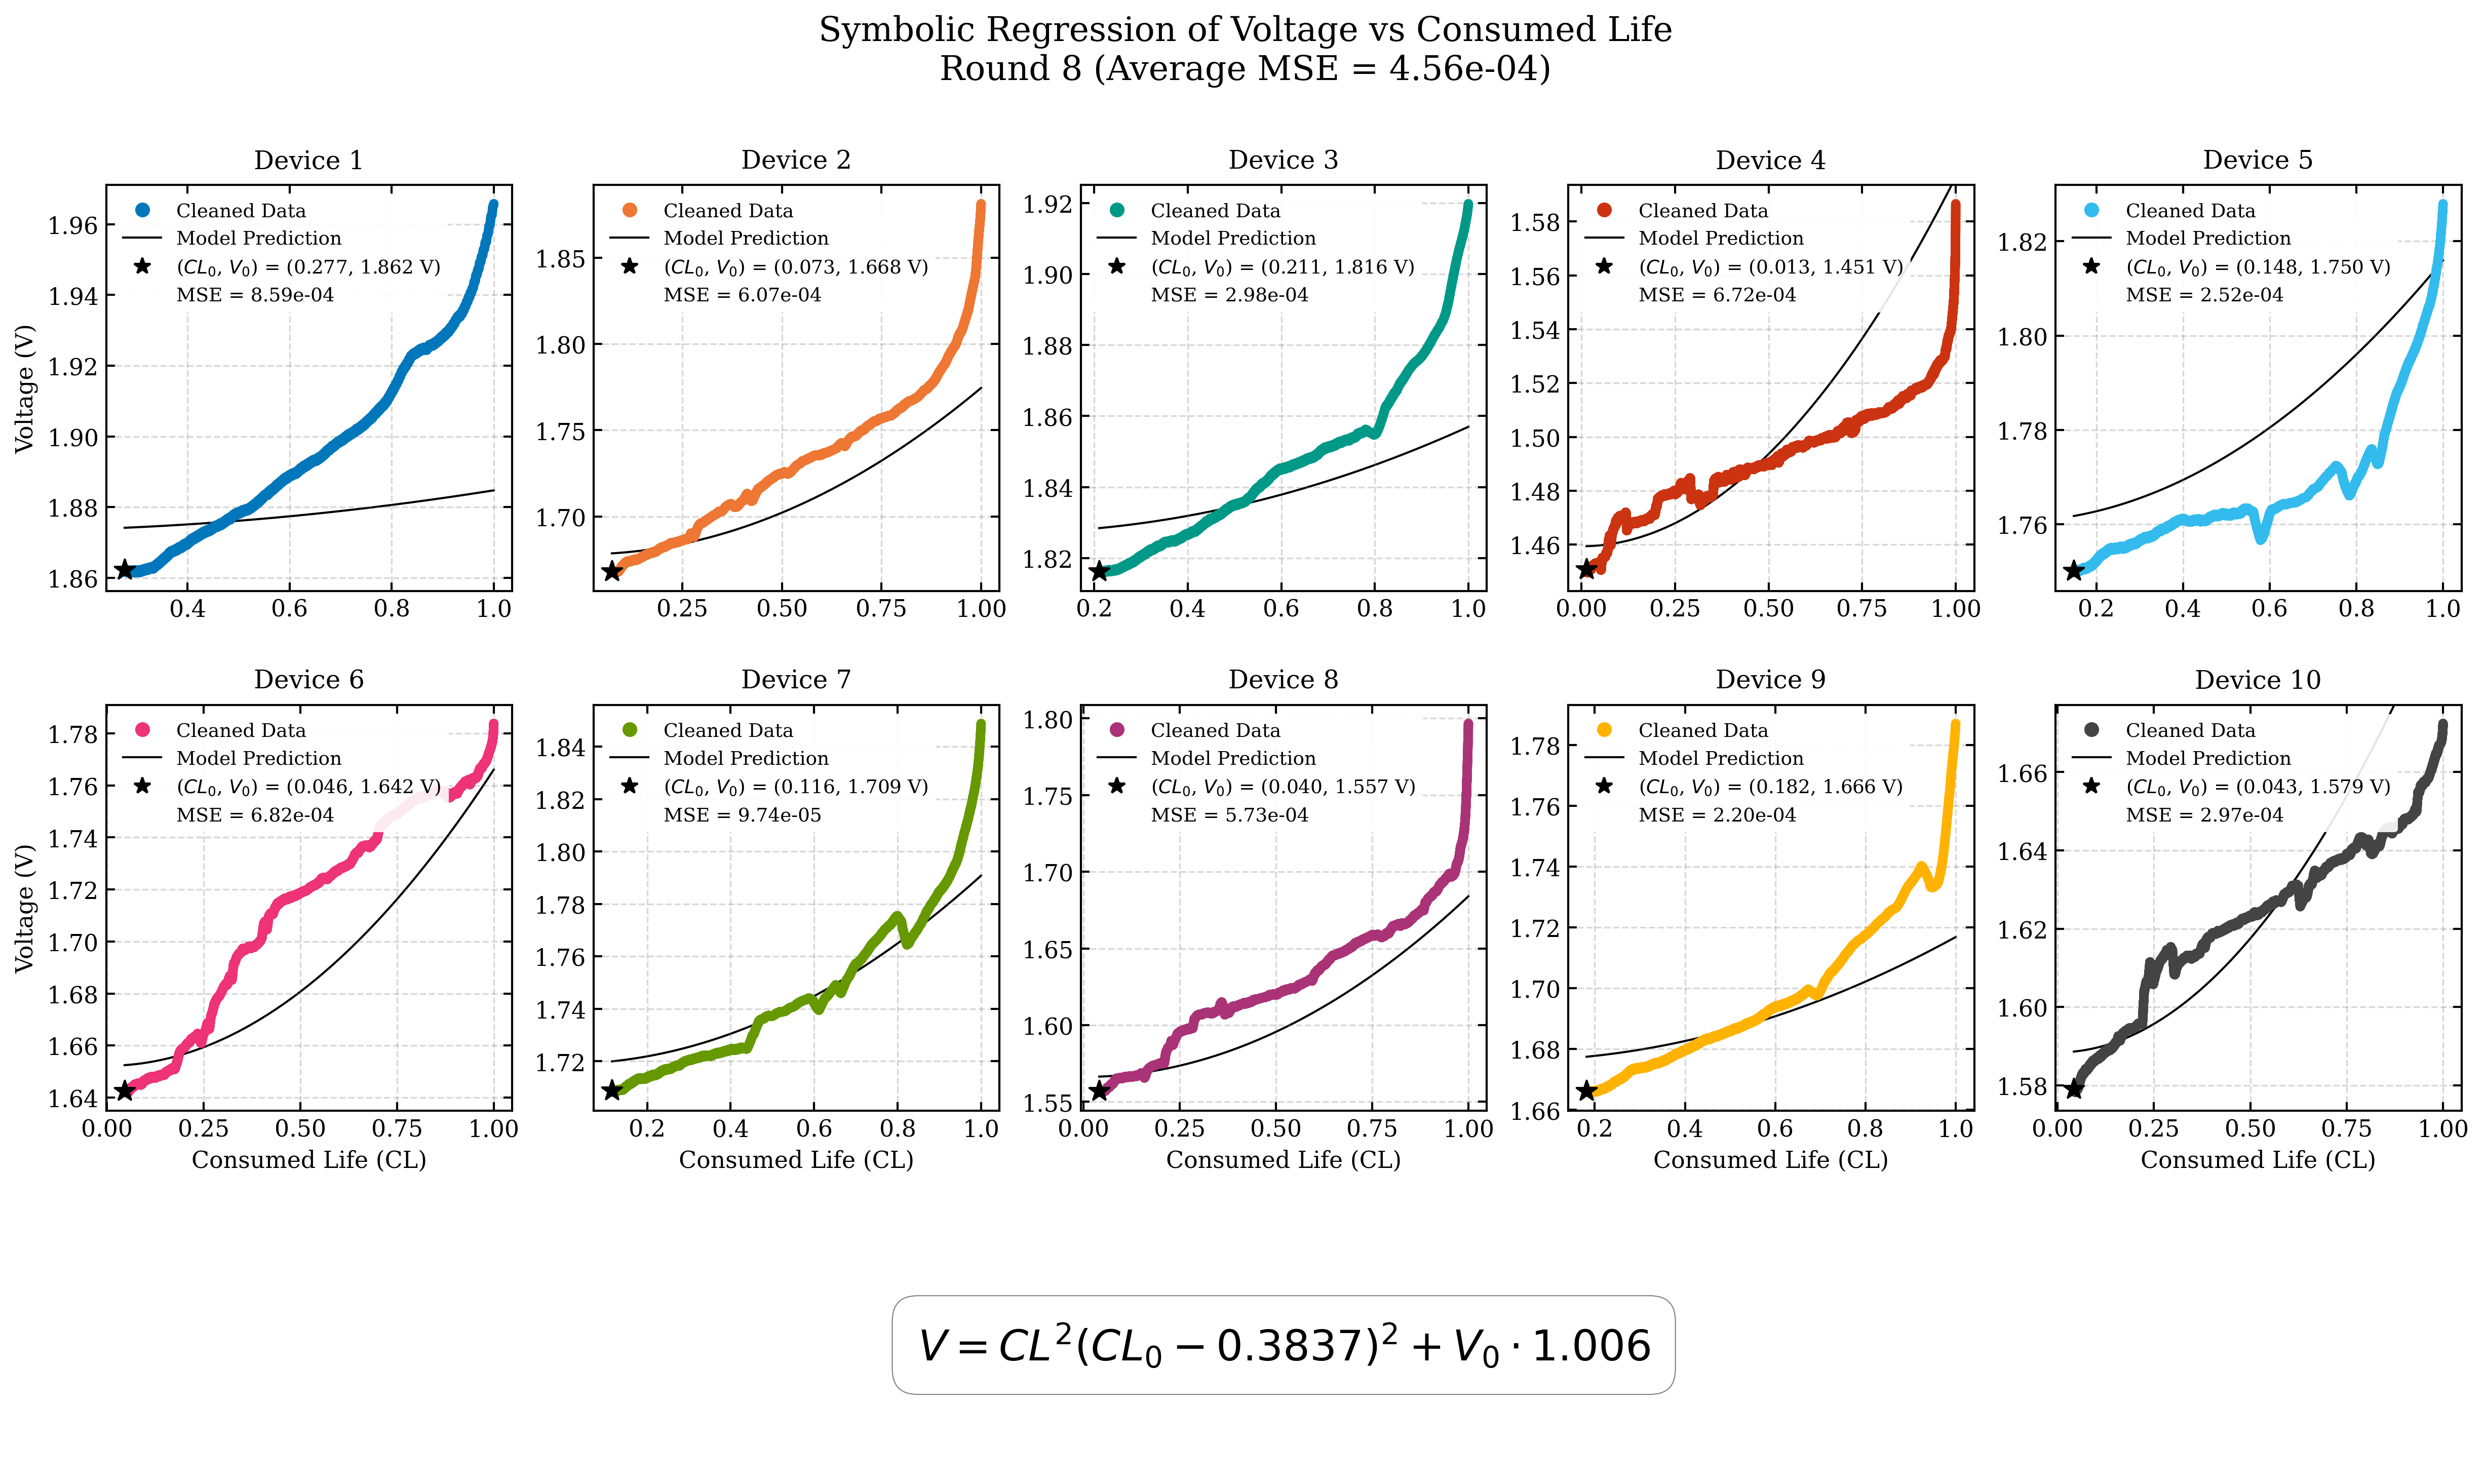

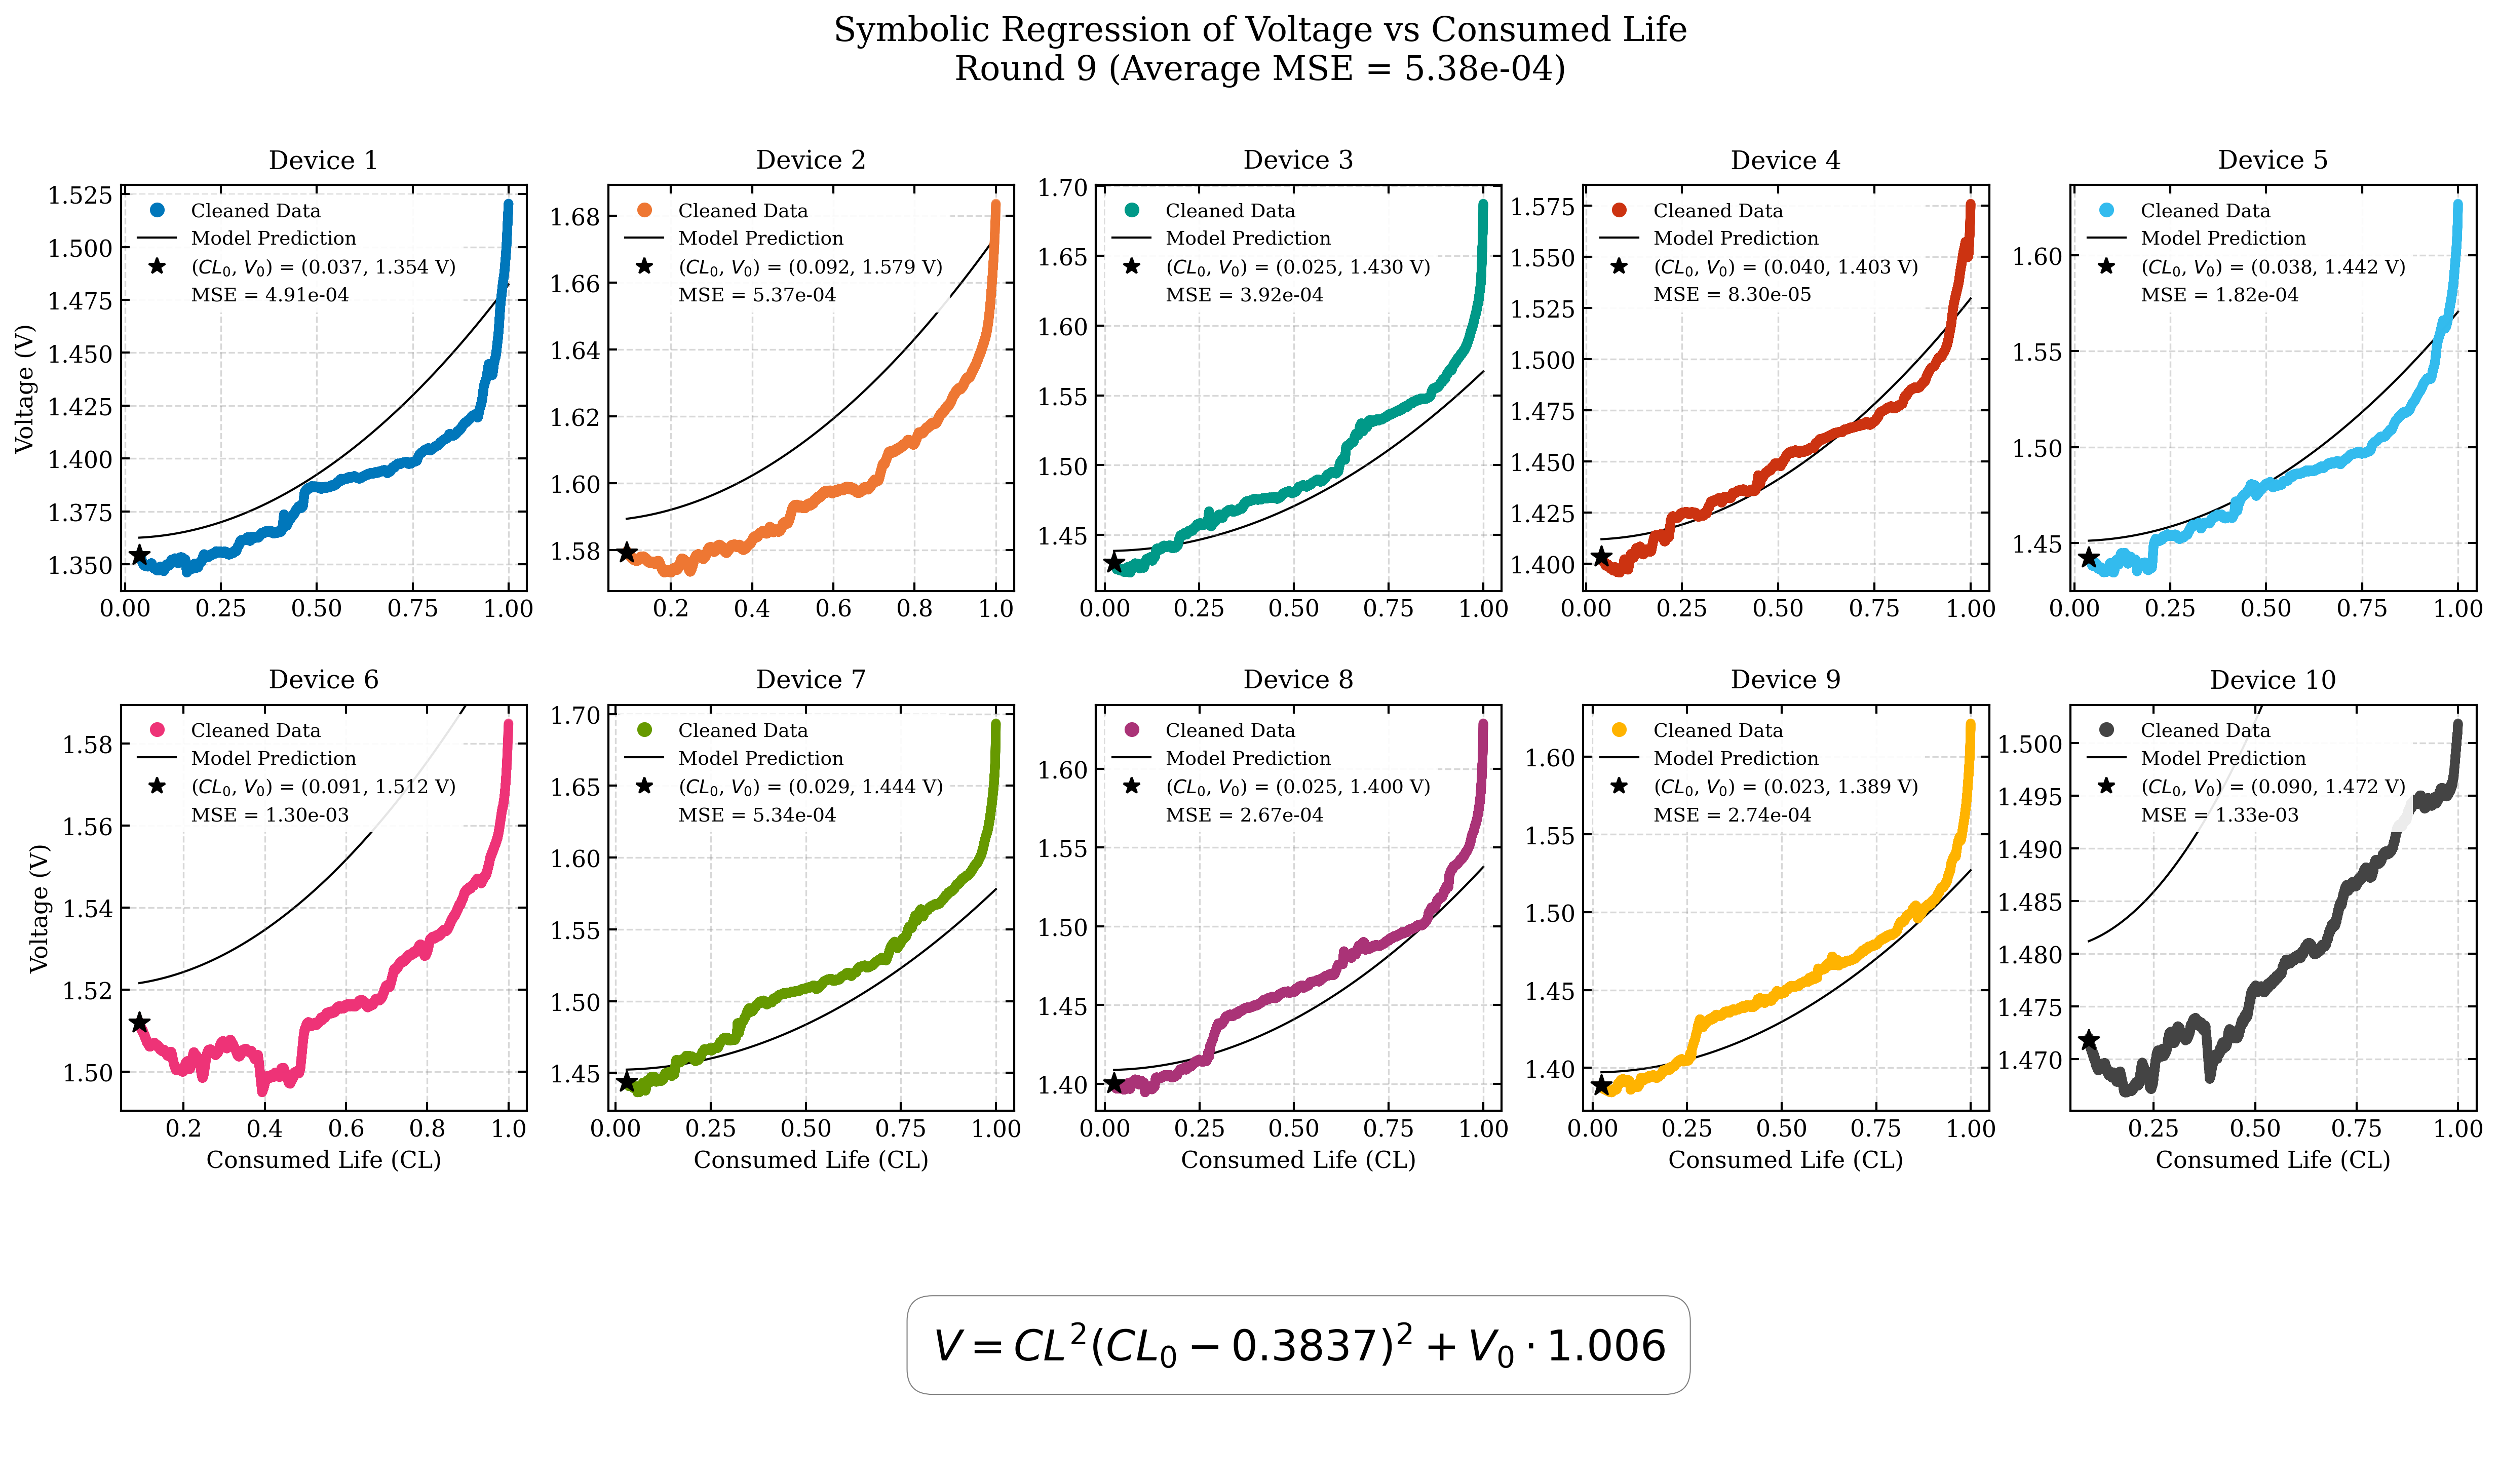

In [13]:
def plot_data_comparison_with_predictions(X, y, model, eq_index=0, round_number=8, save_path=None):
    """Create publication-quality subplots with weighted MSE for Consumed Life (CL) vs Voltage."""
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error
    
    # Set plotting style and parameters
    plt.style.use('default')
    mpl.rcParams.update({
        'font.family': 'serif',
        'font.size': 11,
        'axes.linewidth': 1.0,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.top': True,
        'ytick.right': True,
        'figure.dpi': 300
    })

    # Initialize the figure and grid layout
    fig = plt.figure(figsize=(20, 11))
    gs = plt.GridSpec(3, 5, height_ratios=[1, 1, 0.6], hspace=0.3, wspace=0.2)
    
    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE',
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']
    
    # Filter data for the specified round
    round_mask = X['round'] == round_number
    X_round = X[round_mask]
    y_round = y[round_mask]
    y_pred = model.predict(X_round, eq_index)
    expr_latex = model.latex(eq_index, 4)
    
    # Store individual MSEs
    device_mses = []

    for i in range(10):
        ax = fig.add_subplot(gs[i // 5, i % 5])
        device_num = i + 1
        
        # Filter data for the current device
        device_mask = X_round['device'] == device_num
        if not device_mask.any():
            ax.text(0.5, 0.5, 'No data available', 
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes,
                   fontsize=12)
            continue
        
        device_data = pd.DataFrame({
            'CL': X_round.loc[device_mask, 'CL'],
            'V': y_round[device_mask],
            'predicted_voltage': y_pred[device_mask],
            'V_0': X_round.loc[device_mask, 'V_0'],
            'CL_0': X_round.loc[device_mask, 'CL_0']
        }).sort_values('CL')
        
        if device_data.empty:
            continue
            
        # Calculate the MSE for this device
        device_mse = mean_squared_error(device_data['V'], device_data['predicted_voltage'])
        device_mses.append(device_mse)
        v0 = device_data['V_0'].iloc[0]
        cl0 = device_data['CL_0'].iloc[0]
        
        # Plot actual data
        ax.scatter(device_data['CL'], device_data['V'],
                  label='Experimental Data', 
                  color=colors[i], alpha=0.7, s=20, marker='o', 
                  zorder=2, edgecolors='none')
        
        # Plot model predictions
        ax.plot(device_data['CL'], device_data['predicted_voltage'],
               linestyle='-', color='black', linewidth=1.0,
               label='Model Prediction', zorder=1, alpha=1.0)
        
        # Plot initial point (CL_0, V_0)
        ax.scatter(cl0, v0, color='black', s=100, marker='*',
                  label=f'($CL_0$, $V_0$) = ({cl0:.3f}, {v0:.3f} V)', zorder=3)
        
        ax.set_title(f'Device {device_num}', pad=8, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.3, color='gray')
        ax.tick_params(which='both', direction='in', top=True, right=True, length=4)
        
        # Adjust axis limits with padding
        x_padding = (device_data['CL'].max() - device_data['CL'].min()) * 0.05
        y_padding = (device_data['V'].max() - device_data['V'].min()) * 0.05
        ax.set_xlim(device_data['CL'].min() - x_padding,
                   device_data['CL'].max() + x_padding)
        ax.set_ylim(device_data['V'].min() - y_padding,
                   device_data['V'].max() + y_padding)
        
        ax.set_box_aspect(1)
        
        # Set axis labels for appropriate subplots
        if i >= 5:
            ax.set_xlabel('Consumed Life (CL)', fontsize=11)
        if i % 5 == 0:
            ax.set_ylabel('Voltage (V)', fontsize=11)
        
        # Add legend elements
        legend_elements = [
            Line2D([0], [0], color=colors[i], marker='o', linestyle='None',
                   label='Cleaned Data', markersize=6),
            Line2D([0], [0], color='black', linestyle='-',
                   label='Model Prediction', linewidth=1.0),
            Line2D([0], [0], color='black', marker='*', linestyle='None',
                   label=f'($CL_0$, $V_0$) = ({cl0:.3f}, {v0:.3f} V)',
                   markersize=8),
            Line2D([0], [0], color='none', linestyle='None',
                   label=f'MSE = {device_mse:.2e}')
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=9,
                 framealpha=0.9, edgecolor='none', ncol=1)
    
    # Calculate the weighted MSE (average MSE across devices)
    weighted_mse = np.mean(device_mses)
    
    # Add a title and equation to the figure
    fig.suptitle(f'Symbolic Regression of Voltage vs Consumed Life\nRound {round_number} (Average MSE = {weighted_mse:.2e})',
                 fontsize=16, y=0.98)
    
    ax_eq = fig.add_subplot(gs[2, 2])
    ax_eq.axis('off')
    ax_eq.text(0.5, 0.5, f'$V = {expr_latex}$',
            ha='center', va='center', fontsize=20,
            transform=ax_eq.transAxes,
            bbox=dict(facecolor='white', edgecolor='gray',
                     linewidth=0.5, pad=15,
                     boxstyle='round,pad=0.6'))
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.85])
    
    # Save the figure if save_path is specified
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300,
                   facecolor='white', edgecolor='none')
    
    return fig, weighted_mse

# Example usage:
fig8, mse8 = plot_data_comparison_with_predictions(X, y, model, eq_index=7, round_number=8, 
                                                   save_path='round8_predictions_weighted.png')
fig9, mse9 = plot_data_comparison_with_predictions(X, y, model, eq_index=7, round_number=9, 
                                                   save_path='round9_predictions_weighted.png')
print(f"Average MSE Round 8: {mse8:.2e}")
print(f"Average MSE Round 9: {mse9:.2e}")

